## ДЗ 02. Pytorch

1. "Необходимо нормализовать данные в датасете: написать функцию нормализации и использовать ее внутри класса датасета"

2. "Дополнительное задание: http://archive.ics.uci.edu/ml/datasets/Individual+household+electric+power+consumption - 2075259 measurements gathered in a house located in Sceaux (7km of Paris, France) between December 2006 and November 2010 (47 months). Проделайте весь путь подготовки данных, создания датасета, разделения и обучения модели самостоятельно. Предсказывать нужно Global_active_power."

3. https://drive.google.com/file/d/1rkpumcyjNRzLt4Fh_Qm2AZd8L-wnYS1z/view?usp=sharing
Приложен ноутбук в котором генерируется из большого датасета меньшая его копия. Вам нужно:


- Сгенерировать меньший датасет из 8-10 классов движения

- Изменить функцию разбиения датасета на тестовую и тренировочную часть, увеличив кусок, отводимый на тест

- Обучить уже существующую модель (предварительно проанализировав какие параметры нужно менять)

- Изменить модель для улучшения качества

- Сгенерировать другой датасет с меньшим количеством “кадром” в нашей серии и сравнить с улучшилось или ухудшилось качество предсказания. Провести несколько таких итераций, дать свою оценку уменьшению кадров, назвать оптимальное, на ваш взгляд, их количество.

### Задание 1

In [88]:
import torch
from torch import nn
import numpy as np
import matplotlib.pyplot as plt

use_cuda = torch.cuda.is_available()
# device = torch.device("cpu")
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(device)

cpu


In [89]:
# класс сетки LSTM, наследуемся от nn.Module
# создаём иерархию-структуру сетки + как обработка ошибок происходит?
class LSTM_net(nn.Module):
    def __init__(self,input_dim,hidden_dim,output_dim,layer_num):
        super().__init__()
        self.hidden_dim = hidden_dim # размерность внутренний слой
        self.output_dim = output_dim # размерность выходной слой
        self.lstm = torch.nn.LSTM(input_dim, hidden_dim,layer_num,batch_first=True) # входная размерность, 
        # batch_first=True задаёт порядок следования данных, которые мы передаём в модель. Первая цифра = размер батча
        # получается: кол-во батчей, 1е измерения тензора, 2е изм тензора и т.д.
        #         self.dr = torch.nn.Dropout2d(0.25)
        self.fc = torch.nn.Linear(hidden_dim,output_dim)
        
        
    def forward(self,inputs):
        x = inputs
        lstm_out,(hn,cn) = self.lstm(x)
        out = self.fc(lstm_out[:,-1,:])
        return out

#### Classes:
* sitting down
* clapping
* jump up
* cheer up
* hand waving

In [90]:
import pandas as pd

skeletons = pd.read_csv("skels.csv")

In [91]:
LABELS = {0: "cheer up", 1: "jump up", 2:  "hand waving", 3: "sitting down", 4: "clapping"}

In [92]:
skeletons.head()

,0,1,2,3,4,5,6,7,8,9,...,3366,3367,3368,3369,3370,3371,3372,3373,3374,labels
0,-0.526048,-0.277147,2.987706,-0.606184,-0.010056,3.010000,-0.681454,0.251614,3.020046,-0.708330,...,-0.619659,0.647852,2.708625,-0.598600,0.593635,2.707864,-0.601837,0.592191,2.697301,0
1,-0.325320,-0.560200,3.244968,-0.296753,-0.312155,3.234485,-0.267607,-0.066345,3.212031,-0.286594,...,-0.066076,-0.459657,3.206000,-0.227804,-0.654428,3.002556,-0.231687,-0.655208,3.000000,1
2,-0.134503,0.387048,3.797468,-0.135835,0.648782,3.669347,-0.137341,0.904024,3.529603,-0.131990,...,-0.332011,0.576840,3.451273,0.011452,0.521624,3.528420,-0.011325,0.589017,3.480000,1
3,0.371560,-0.187321,2.853457,0.388124,0.118966,2.756247,0.402399,0.418116,2.643035,0.354668,...,0.106246,0.619960,2.735462,0.352891,-0.375651,2.625237,0.465385,-0.316062,2.651301,2
4,-0.193082,-0.178566,2.814345,-0.196894,0.114788,2.849780,-0.198289,0.400548,2.872416,-0.178771,...,-0.567993,-0.426740,2.994171,0.102882,-0.492025,3.011537,0.063065,-0.435819,3.055625,3


## Dataloader

In [188]:
import torch
import matplotlib.pyplot as plt
import torchvision
from torchvision import datasets, transforms

from sklearn.preprocessing import MinMaxScaler

In [94]:
from torch.utils.data import DataLoader, Dataset

``` DataLoader(dataset, batch_size=1, shuffle=False, sampler=None,
           batch_sampler=None, num_workers=0, collate_fn=None,
           pin_memory=False, drop_last=False, timeout=0,
           worker_init_fn=None) ```

Класс Dataset и класс Dataloader помогают передавать собственные обучающие данные в сеть. 
Класс Dataset используется для обеспечения интерфейса для доступа ко всем обучающим или тестовым образцам в вашем наборе данных. Для этого необходимо реализовать как два обязательных метода, __getitem__ и __len_. 

In [95]:
class Test_Dataset(Dataset):
    def __init__(self):
        self.samples = list(range(0, 100)) ##генерируем случайные данные
        # Все подготовления данных происходят в инициализации:
        # - разделение данных на train/test/ validate
        # - аугментация (трансформация) данных 
        # - чтние аннотаций
        # - считывание по индексу

    def __len__(self):
        # # Возвращает данные и лейблы
        # - Применяет выбранные трансформации к данным
        # - отправление данных на гпу
        # - лучше возвращать данные как тензор или словарь
        return len(self.samples) #возвращаем данные, длину списка или что?

    def __getitem__(self, idx): # вытаскиваем по индексу из сформированных данных (см. __Init__ ) элемент и метку
        return (self.samples[idx], label) 
    

In [189]:
class Skeleton_Dataset(Dataset):
    def __init__(self, file_path, transform=None): # путь к файлу, нужно ли трансформировать
        self.data = pd.read_csv(file_path) # читаем файл
        self.transform = transform
#         if self.transform:
#             self.data = self.transformation(self.data) # применяем или не применяем трансформ ко всему датасету

    def __len__(self):
        return len(self.data) # возвращаем длину данных
    
    
    def __getitem__(self, idx):
        item = np.asarray(self.data.iloc[idx,:-1]).reshape(45,75) # превращаем в np.array, достаём из данных по индексу
        # кроме последнего столбца и эти данные решейпим в размер 45,75
        label = self.data.iloc[idx,-1]# достаём метку (последний столбец пандас-датафрейма)
        
        if self.transform != None:# если трансформировать надо, то трансформируем
            item = self.transformation(item)
            
        return (item, label) # возвращаем объект + метку
    
    # функция для нормализации датасета (нормализацию проводим по всему набору кадров (в нашем примере 45)
    def transformation(self, item):
        scaler = MinMaxScaler()
        scaler.fit(item)
        item = scaler.transform(item)
        return item

In [199]:
# загружаем датасет
dataset = Skeleton_Dataset(file_path = "skels.csv", transform=True)

In [198]:
# считались ли метки
skel, lab = dataset.__getitem__(41)
LABELS[lab]

'sitting down'

In [197]:
# нормализованные данные как выглядят
skel[1]

array([5.80888431e-03, 9.93672740e-01, 0.00000000e+00, 1.99720004e-03,
       9.96633160e-01, 1.19032694e-02, 4.71100459e-02, 9.98081168e-01,
       5.86962653e-01, 1.15373624e-01, 9.98288674e-01, 6.70147424e-01,
       3.88853155e-02, 9.96174640e-01, 2.78802418e-01, 2.19953566e-03,
       8.73241985e-01, 8.89358317e-01, 6.27205194e-02, 9.97164521e-01,
       7.22950940e-01, 1.70680034e-01, 9.68052065e-01, 5.56006584e-01,
       5.17160640e-03, 9.97457313e-01, 4.20368406e-02, 5.55318747e-03,
       9.95971588e-01, 3.64000586e-03, 6.17711445e-03, 9.23317198e-01,
       5.02295890e-02, 1.75776604e-02, 8.87758106e-01, 2.88391530e-01,
       0.00000000e+00, 8.92744790e-01, 5.33324126e-02, 3.35538851e-03,
       2.96105613e-01, 3.38649747e-01, 7.44482315e-01, 7.15785390e-01,
       4.18527401e-01, 1.79337112e-01, 7.29101034e-01, 8.58181723e-01,
       5.09237514e-02, 9.95122967e-01, 0.00000000e+00, 1.43239078e-02,
       4.58747065e-01, 9.78641708e-01, 3.50954283e-03, 5.86545320e-01,
      

In [193]:
# чтобы нарисовать, нужно ришейпить в трёхмерный тензор
skels_for_draw = skel.reshape(-1,25,3)
skels_for_draw.shape

(45, 25, 3)

<IPython.core.display.Javascript object>


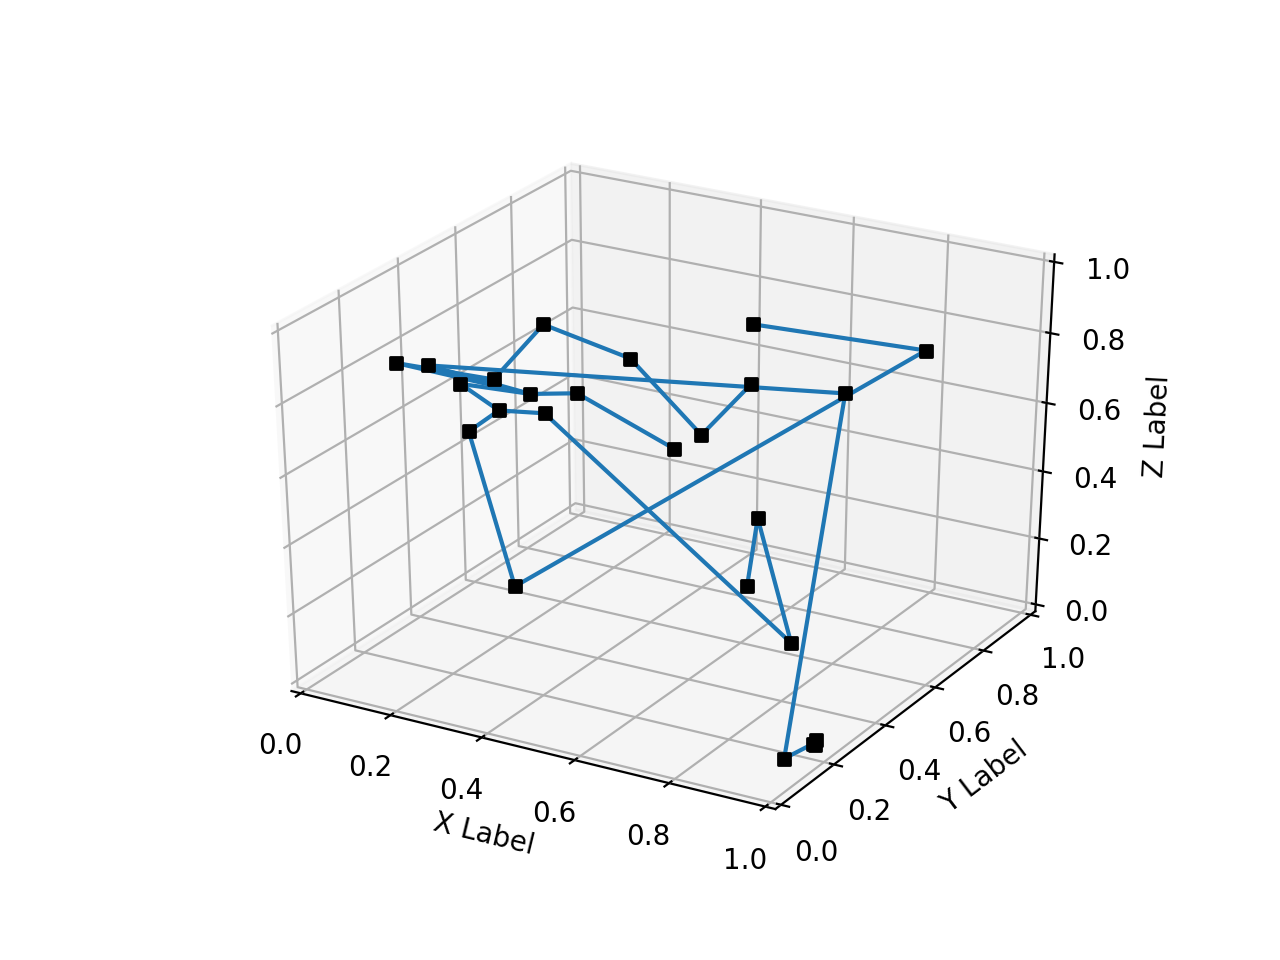

In [195]:
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401 unused import
import mpl_toolkits.mplot3d as plt3d
import matplotlib.animation as animation

import matplotlib.pyplot as plt
import numpy as np
from time import sleep

%matplotlib notebook

# пары костей. Для чего это нужно?
bone_pairs = (
    (1, 2), (2, 21), (3, 21), (4, 3), (5, 21), (6, 5),
    (7, 6), (8, 7), (9, 21), (10, 9), (11, 10), (12, 11),
    (13, 1), (14, 13), (15, 14), (16, 15), (17, 1), (18, 17),
    (19, 18), (20, 19), (22, 23), (21, 21), (23, 8), (24, 25),(25, 12)
)

i = 0 # счётчик в ноль
# for for_draw in skels_for_draw:
i = i + 1
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
for_draw = skels_for_draw[10]

for pair in bone_pairs:
    xs = for_draw[pair[0]-1][0], for_draw[pair[1]-1][0]
    ys = for_draw[pair[0]-1][1], for_draw[pair[1]-1][1]
    zs = for_draw[pair[0]-1][2], for_draw[pair[1]-1][2]

    line = plt3d.art3d.Line3D(zs, xs, ys)
    ax.add_line(line)


for x,y,z in for_draw:
    ax.scatter(z, x, y, color='black', marker='s')

    ax.set_ylim((0, 1))
    ax.set_zlim((0, 1))
    ax.set_xlim((0, 1))


    ax.set_xlabel('X Label')
    ax.set_ylabel('Y Label')
    ax.set_zlabel('Z Label')


    plt.show()

# #     plt.savefig('pics_1/test_' +str(i)+'.png', bbox_inches='tight')
# #     plt.clf()

### Итоги: 

Добавлен нормализация отдельного item, т.к. нормировать датасет в целом, вероятно, будет ошибкой. Нам нужно нормализацию в пределах одного наблюдения (отрезка из 45 кадров). Таким образом, нормализация вызывается только при вызове отдельного объекта (def __getitem__), а не загрузки датасета в целом.